# Advanced Data Science with IBM

## Use Case: Fault prediction for a gear bearing from IoT sensors (anomaly detection)
The goal of this use case is to predict as soon as possible when the gear bearing should be changed or maintained
### EDA and ETL

This notebook I have implemented on the local system.  
Source of the data: : http://data-acoustics.com/measurements/bearing-faults/bearing-4/
I had to download the zip file to my workstation. It contains 3 test sets of data with tab separated text files without file extension. I work with data set 2 which contains 983 files<br>
This notebook runs on my local machine.<br>
**Goals of this notebook:**
* Create 3 csv files that can be used for modeling in the next step
* ETL
* Expoloratory data analysis (EDA)

In [18]:
#All import statements
import numpy as np
import pandas as pd
import os, csv, glob, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [4]:
# define source folder and add csv extension to all files
folder = './data/2nd_test/'
for filename in glob.iglob(os.path.join(folder, '*.*')):
    if filename[-4:] != '.csv':
        os.rename(filename, filename + '.csv')

In [5]:
# the file name of the csv files represents the date and time of the recordings of the sensors. 
# This date and time info I will save as additional column which will be needed later in the project
all_files = glob.glob(folder + "/*.csv")
df_tmp = []
date_time_str = '2004.02.19.06.22.39' 
date_time_obj = datetime.datetime.strptime(date_time_str, '%Y.%m.%d.%H.%M.%S')

# read all csv files and add the contents to the dataframe df_all
for filename in all_files:
    df = pd.read_csv(filename, delimiter="\t",index_col=None, names=["bearing1", "bearing2", "bearing3", "bearing4"], header=None)
    df['date'] = datetime.datetime.strptime(os.path.basename(filename)[:-4], '%Y.%m.%d.%H.%M.%S') 
    df_tmp.append(df)
    
df_all = pd.concat(df_tmp, axis=0, ignore_index=True,sort=True)
df_all.index = pd.DatetimeIndex(df_all.date)
#df_all['ID'] = np.arange(len(df_all)) # column ID will be useful in later steps of the project

In [6]:
df_all.shape

(20131840, 5)

In [7]:
# column date is only used for index so we drop it
df_all = df_all.drop(['date'], axis=1)
df_all = df_all.abs() # minus values not needed
df_all.head()

,bearing1,bearing2,bearing3,bearing4
date,,,,
2004-02-12 10:42:39,0.088,0.127,0.154,0.022
2004-02-12 10:42:39,0.022,0.178,0.073,0.022
2004-02-12 10:42:39,0.015,0.066,0.259,0.056
2004-02-12 10:42:39,0.083,0.122,0.005,0.073
2004-02-12 10:42:39,0.056,0.029,0.073,0.007


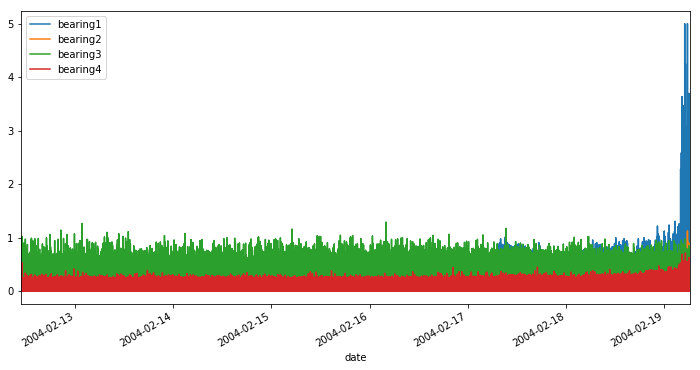

In [8]:
# plot all data - Attention: time consuming
df_all.plot(figsize = (12,6))

In [9]:
# to reduce the amount of data we take the average of 10 minute intervals
df_min = df_all.resample("10Min").mean()

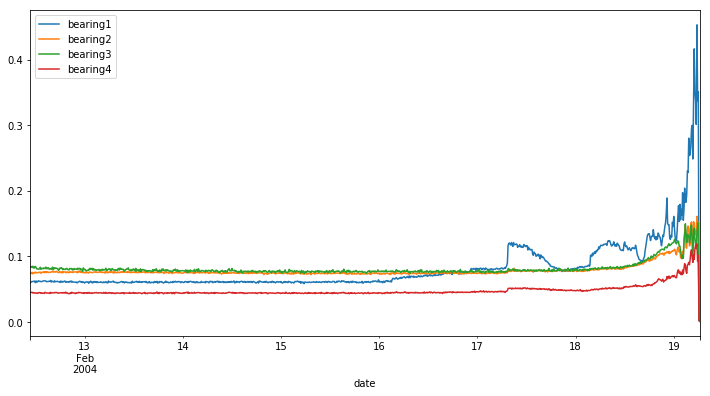

In [10]:
# check if the distirubution of data is still representative for the original data
df_min.plot(figsize = (12,6))

In [12]:
#check rows and columns
df_min.shape

(983, 4)

In [14]:
#data should show the sensor data every 10 minutes
df_min.head()

,bearing1,bearing2,bearing3,bearing4
date,,,,
2004-02-12 10:40:00,0.058997,0.074008,0.084439,0.044540
2004-02-12 10:50:00,0.060239,0.074223,0.083922,0.044442
2004-02-12 11:00:00,0.061453,0.073843,0.084462,0.045081
2004-02-12 11:10:00,0.061361,0.075606,0.082837,0.045118
2004-02-12 11:20:00,0.061669,0.073281,0.084886,0.044171


In [16]:
#normalize the data between 0 and 1
def scaleData(data):
    #normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))

    return scaler.fit_transform(data)

In [19]:
min_scale = pd.DataFrame(scaleData(df_min), columns = df_min.columns, index = df_min.index)

In [20]:
# the test started on Feb 12th 2004 and ended on Feb 19th 2004. The failure arised always at the end, so I decided
# to choose healthy data from Feb 12th to Feb 13th
df_ok = min_scale['2004-02-12 10:40:00':'2004-02-13 23:59:59']

In [21]:
# all data starting from Feb 15th will be test data
df_nok = min_scale['2004-02-14 00:00:00':'2004-02-19 06:22:39']

In [22]:
print(df_ok.head())
print(df_nok.head())

                     bearing1  bearing2  bearing3  bearing4
date                                                       
2004-02-12 10:40:00  0.127896  0.457060  0.556003  0.365093
2004-02-12 10:50:00  0.130644  0.458403  0.552573  0.364258
2004-02-12 11:00:00  0.133330  0.456029  0.556160  0.369705
2004-02-12 11:10:00  0.133125  0.467033  0.545364  0.370022
2004-02-12 11:20:00  0.133806  0.452518  0.558971  0.361946
                     bearing1  bearing2  bearing3  bearing4
date                                                       
2004-02-14 00:00:00  0.131030  0.458933  0.513701  0.360847
2004-02-14 00:10:00  0.130030  0.461237  0.512931  0.356716
2004-02-14 00:20:00  0.130544  0.463139  0.510757  0.365246
2004-02-14 00:30:00  0.133485  0.466686  0.508804  0.359752
2004-02-14 00:40:00  0.132700  0.466122  0.519833  0.364788


In [24]:
print(df_ok.dtypes)
print(df_nok.dtypes)

bearing1    float64
bearing2    float64
bearing3    float64
bearing4    float64
dtype: object
bearing1    float64
bearing2    float64
bearing3    float64
bearing4    float64
dtype: object


In [25]:
# get an overview with statistical measures
print(df_ok.describe())
print(df_nok.describe())

         bearing1    bearing2    bearing3    bearing4
count  224.000000  224.000000  224.000000  224.000000
mean     0.132014    0.466941    0.525509    0.361078
std      0.001858    0.004504    0.011830    0.004477
min      0.127639    0.452518    0.499072    0.350592
25%      0.130690    0.464006    0.517033    0.358072
50%      0.131935    0.467231    0.524785    0.361095
75%      0.133341    0.469910    0.533294    0.364009
max      0.137210    0.480742    0.558971    0.374626
         bearing1    bearing2    bearing3    bearing4
count  759.000000  759.000000  759.000000  759.000000
mean     0.189501    0.490758    0.538471    0.402556
std      0.097355    0.082885    0.087240    0.090404
min      0.000000    0.000000    0.000000    0.000000
25%      0.132659    0.457394    0.503614    0.361217
50%      0.156787    0.462365    0.511420    0.369142
75%      0.222079    0.483364    0.525612    0.413274
max      1.000000    1.000000    1.000000    1.000000


In [27]:
# check nan values
df_min.isna().any()

bearing1    False
bearing2    False
bearing3    False
bearing4    False
dtype: bool

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CB0049BE80>,
      dtype=object)

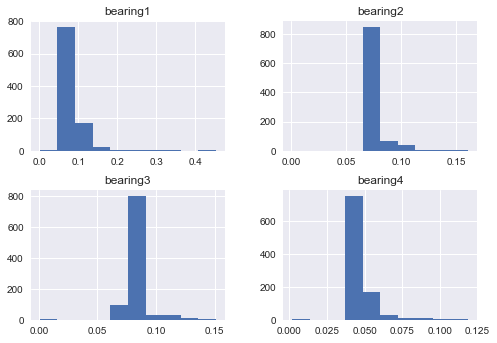

In [28]:
#show the distribution of the data for evey bearing
plt.style.use('seaborn')
df_min.hist(column=["bearing1", "bearing2","bearing3","bearing4"]) 

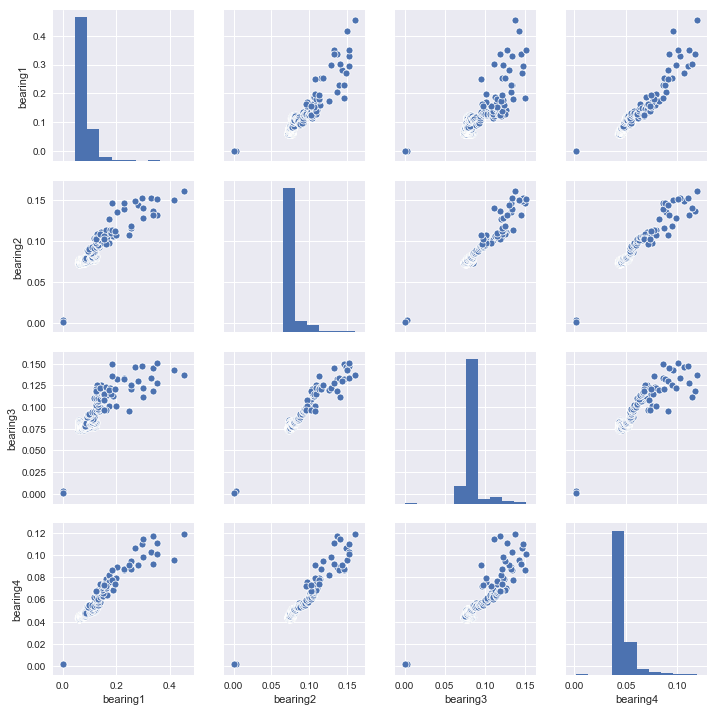

In [30]:
# check correlations
sns.pairplot(df_min.loc[:,df_all.dtypes == 'float64'])

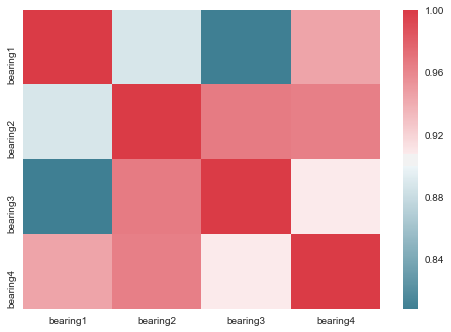

In [31]:
# check with heat map
corr = df_min.loc[:,df_min.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

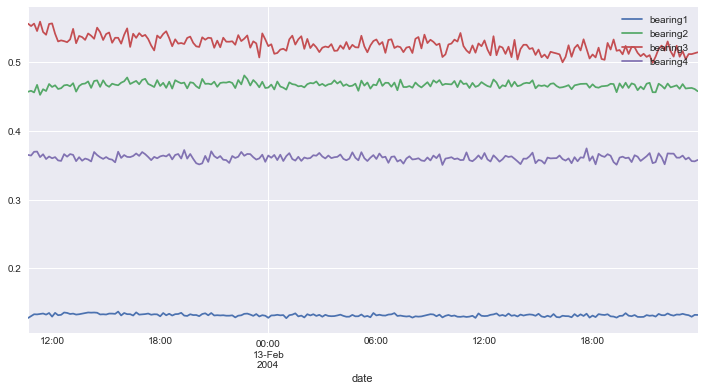

In [32]:
#plot the data withoud anomalies
df_ok.plot(figsize = (12,6))

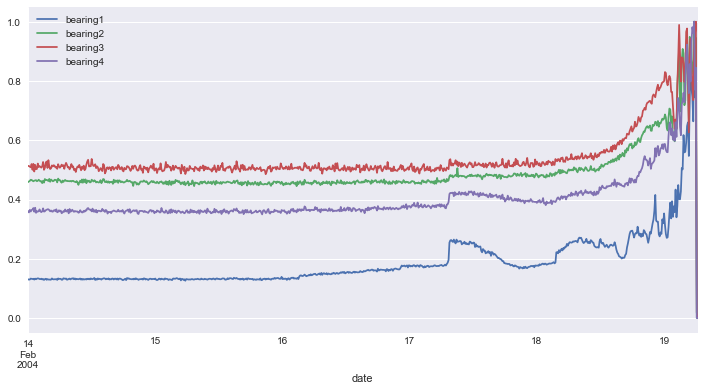

In [33]:
#plot the data with anomalies
df_nok.plot(figsize = (12,6))

In [34]:
# create 3 csv files which will be used for modeling
df_ok.to_csv('./data/df_ok.csv', index=True)
df_nok.to_csv('./data/df_nok.csv', index=True)
#df_all.to_csv('./data/df_all.csv', index=True)